<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/ML_gradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from keras import layers
from keras import models
import keras

In [1]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

In [5]:
from os import listdir

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = cv2.imread(path + image)
        loadedImages.append(cv2.resize(img,(300,300)))

    return np.array(loadedImages)
test_normales = loadImages("/content/drive/MyDrive/test/NORMAL/")
test_neumonia= loadImages("/content/drive/MyDrive/test/PNEUMONIA/")

In [24]:
from keras.applications import EfficientNetB3 

Efficient = EfficientNetB3 (weights='imagenet',
                  include_top=True,
                  input_shape=(300, 300, 3))
Efficient.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 300, 300, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 300, 300, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [8]:
arr_neum=test_neumonia[np.random.choice(range(0,len(test_neumonia)),size=2,replace=False)]
arr_norm=test_normales[np.random.choice(range(0,len(test_normales)),size=2,replace=False)]

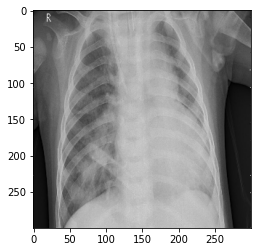

In [90]:
from keras.models import load_model
model = load_model('neumonia_full_trained.h5')

In [11]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 1536)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          884800    
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               147712    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                      

In [36]:
img=arr_neum[0]
img_array = np.array(img).astype('float32')[:,:,:3]
img_array = np.expand_dims(img_array, axis=0)

In [76]:
grad_cam, saliency = make_gradcam_heatmap(img_array/255, 
                                          model, 
                                          'conv2d_2', 
                                          ['flatten_2','dense_6','dense_7','dense_8'])

tf.Tensor(1, shape=(), dtype=int64)


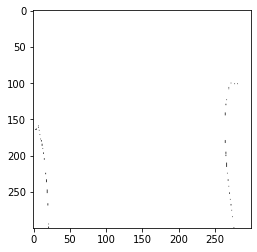

In [86]:
plt.imshow(np.array(img).astype('float32')[:,:])

In [77]:
from skimage.transform import resize
def show_hotmap (img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
    '''
    img     :    Image
    heatmap :    2d narray
    '''
    resized_heatmap=resize(heatmap, img.size)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()

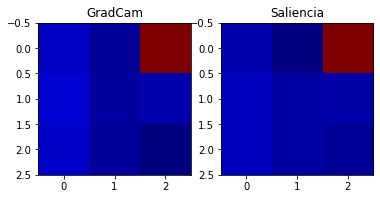

In [78]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

In [87]:
show_hotmap(img=np.array(img).astype('float32')[:,:], heatmap=grad_cam, title=f'Grad Cam: {model.name}')

TypeError: ignored